In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

데이터 불러오기

In [2]:
data_path= "data"
normal_files = glob.glob(data_path+'/normal/'+'*.csv')
anormal_drift_files = glob.glob(data_path+'/anormal_drift/'+'*.csv')
anormal_erratic_files = glob.glob(data_path+'/anormal_erratic/'+'*.csv')
anormal_hardover_files = glob.glob(data_path+'/anormal_hardover/'+'*.csv')
anormal_spike_files = glob.glob(data_path+'/anormal_spike/'+'*.csv')
anormal_stuck_files = glob.glob(data_path+'/anormal_stuck/'+'*.csv')

In [3]:
print(normal_files)

['data/normal\\normal_data0.csv', 'data/normal\\normal_data1.csv', 'data/normal\\normal_data10.csv', 'data/normal\\normal_data100.csv', 'data/normal\\normal_data101.csv', 'data/normal\\normal_data102.csv', 'data/normal\\normal_data103.csv', 'data/normal\\normal_data104.csv', 'data/normal\\normal_data105.csv', 'data/normal\\normal_data106.csv', 'data/normal\\normal_data107.csv', 'data/normal\\normal_data108.csv', 'data/normal\\normal_data109.csv', 'data/normal\\normal_data11.csv', 'data/normal\\normal_data110.csv', 'data/normal\\normal_data111.csv', 'data/normal\\normal_data112.csv', 'data/normal\\normal_data113.csv', 'data/normal\\normal_data114.csv', 'data/normal\\normal_data115.csv', 'data/normal\\normal_data116.csv', 'data/normal\\normal_data117.csv', 'data/normal\\normal_data118.csv', 'data/normal\\normal_data119.csv', 'data/normal\\normal_data12.csv', 'data/normal\\normal_data120.csv', 'data/normal\\normal_data121.csv', 'data/normal\\normal_data122.csv', 'data/normal\\normal_data1

In [4]:
def dataReader(path_names):
    data_n = pd.DataFrame() #판다스의 데이터프레임 형태로 프레임 생성
    for i in path_names:
        low_data = pd.read_csv(i)# 판다스 형태로 읽음, 한csv파일씩 읽기 떄문에 다음 라인에서 하나로 합침
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

In [5]:
normal_datas = dataReader(normal_files)
drift_datas = dataReader(anormal_drift_files)
erratic_datas = dataReader(anormal_erratic_files)
hardover_datas = dataReader(anormal_hardover_files)
spike_datas = dataReader(anormal_spike_files)
stuck_datas = dataReader(anormal_stuck_files)

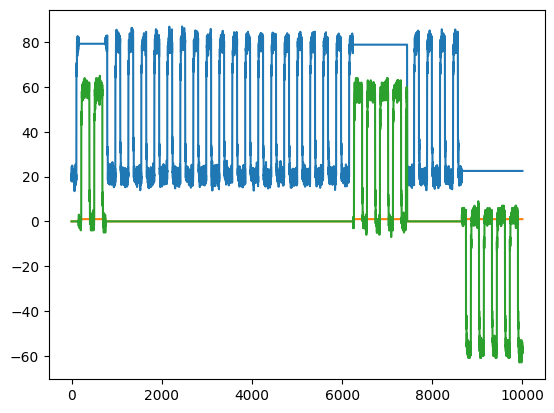

In [6]:
import matplotlib.pyplot as plt

plt.plot(stuck_datas[0:10000])

LSTM 쓸 수 있게 데이터 shape 변경

In [7]:
def Xy_to_XyNtime(X,ntime_in,ntime_out): #X변형할 시계열 데이터 n_time_in 만큼 하나의 input으로 봄, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_in -ntime_out + 1
    X_ntime = [0 for _ in range(nsample)]
    for i in range(nsample):
        X_ntime[i] = X[i:i+ntime_in]
    X_train = np.reshape(X_ntime,(nsample,ntime_in,1)) #2차원 배열을 3차원 배열으로
    print(X_train.shape)
    y_nfuture = [0 for _ in range(nsample)]
    for i in range(nsample):
        y_nfuture[i] = X[i+ntime_in:i+ntime_in+ntime_out]
    y_train = np.array(y_nfuture)
    print(y_train.shape)
    return X_train,y_train

In [ ]:
n_time_in = 10
ntime_out = 1

In [8]:
X_train, y_train = Xy_to_XyNtime(normal_datas['value'],n_time_in,ntime_out)

(4031990, 10, 1)
(4031990, 1)


Train

In [9]:
from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras.models import Sequential

LSTM_AE_model = Sequential()

LSTM_AE_model.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(ntime_out))

LSTM_AE_model.compile(loss="mean_squared_error",optimizer='adam')

In [10]:
LSTM_AE_model.fit(X_train, y_train, epochs=1, batch_size=100, verbose=0)

Test

In [152]:
test_data = erratic_datas

In [153]:
X_test,y_test =Xy_to_XyNtime(test_data['value'][:10000],n_time_in,ntime_out)

(9990, 10, 1)
(9990, 1)


In [154]:
y_predict = LSTM_AE_model.predict(X_test,verbose=0)
y_predict.shape

(9990, 1)

In [155]:
test_size = len(y_predict)

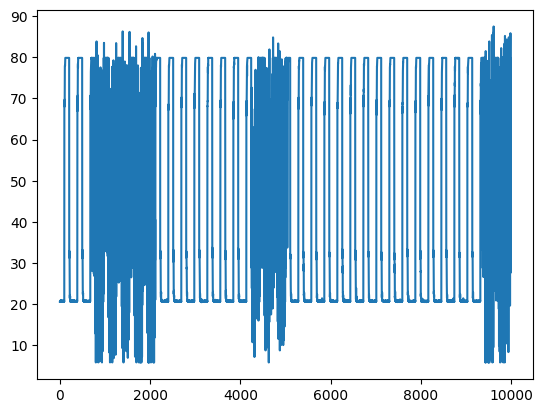

In [156]:
plt.plot(y_predict[ntime_out:test_size])

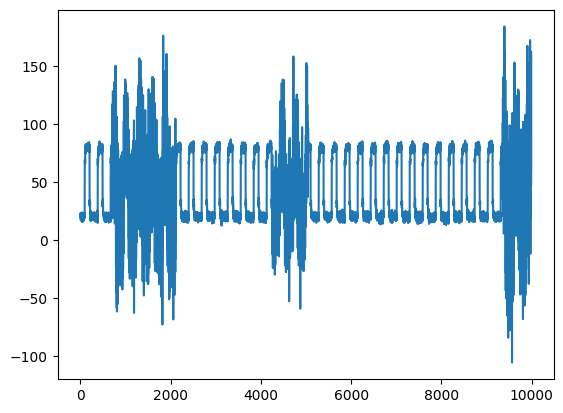

In [157]:
plt.plot(y_test[:test_size-ntime_out])

In [158]:
def MSE(target,predict):
    return (1.0/2.0)*(target-predict)**2

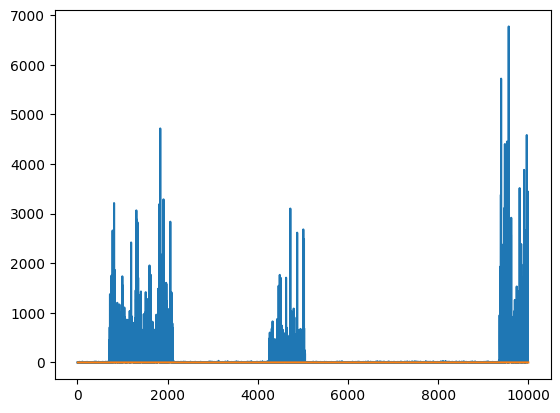

In [159]:
plt.plot(MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
#plt.plot(y_test[:test_size-ntime_out]-y_predict[ntime_out:test_size])
plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
#plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값

In [160]:
MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size]).shape

(9989, 1)

In [161]:
test_data['error'][n_time_in:test_size+n_time_in-ntime_out].shape

(9989,)

In [162]:
def over_num(thresold,np_list):
    for i in range(len(np_list)):
        if(np_list[i]>= thresold):
            print(i,np_list[i])
over_num(100,y_test[:test_size-ntime_out]-y_predict[ntime_out:test_size])

9395 [106.95187492]


In [163]:
over_num(1,np.array(test_data['error'][n_time_in:test_size]))

710 1.0
711 1.0
712 1.0
713 1.0
714 1.0
715 1.0
716 1.0
717 1.0
718 1.0
719 1.0
720 1.0
721 1.0
722 1.0
723 1.0
724 1.0
725 1.0
726 1.0
727 1.0
728 1.0
729 1.0
730 1.0
731 1.0
732 1.0
733 1.0
734 1.0
735 1.0
736 1.0
737 1.0
738 1.0
739 1.0
740 1.0
741 1.0
742 1.0
743 1.0
744 1.0
745 1.0
746 1.0
747 1.0
748 1.0
749 1.0
750 1.0
751 1.0
752 1.0
753 1.0
754 1.0
755 1.0
756 1.0
757 1.0
758 1.0
759 1.0
760 1.0
761 1.0
762 1.0
763 1.0
764 1.0
765 1.0
766 1.0
767 1.0
768 1.0
769 1.0
770 1.0
771 1.0
772 1.0
773 1.0
774 1.0
775 1.0
776 1.0
777 1.0
778 1.0
779 1.0
780 1.0
781 1.0
782 1.0
783 1.0
784 1.0
785 1.0
786 1.0
787 1.0
788 1.0
789 1.0
790 1.0
791 1.0
792 1.0
793 1.0
794 1.0
795 1.0
796 1.0
797 1.0
798 1.0
799 1.0
800 1.0
801 1.0
802 1.0
803 1.0
804 1.0
805 1.0
806 1.0
807 1.0
808 1.0
809 1.0
810 1.0
811 1.0
812 1.0
813 1.0
814 1.0
815 1.0
816 1.0
817 1.0
818 1.0
819 1.0
820 1.0
821 1.0
822 1.0
823 1.0
824 1.0
825 1.0
826 1.0
827 1.0
828 1.0
829 1.0
830 1.0
831 1.0
832 1.0
833 1.0
834 1.0


Evaluation

In [164]:
perdict_error =MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size])
perdict_error = perdict_error.reshape(len(perdict_error))
perdict_error.shape

(9989,)

In [165]:
real_error = np.array(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
real_error.shape

(9989,)

In [166]:
def evaluation(perdict_error,real_error,threshold):
    predict_size = len(perdict_error)
    #오차행렬 초기화
    tp = 0
    fp = 0
    tn = 0
    fn = 0 

    for i in range(predict_size):
        modelP = 0
        modelN = 0
        trueP = 0
        trueN = 0
        # 모델에 대한 P,N
        if(perdict_error[i] > threshold):
            modelP = 1
        else:
            modelN = 1
        #실제값에 대한 P,N
        if(real_error[i] == 1):
            trueP = 1
        else:
            trueN = 1
        #오차 행렬 업데이트
        if(modelP==1 and trueP == 1):
            tp += 1
        elif(modelP == 1 and trueN == 1):
            fp += 1
        elif(modelN == 1 and trueN == 1):
            tn += 1
        elif(modelN == 1 and trueP == 1):
            fn += 1
    Accuracy = float(tp+tn)/float(tp+tn+fp+fn) # 전체 예측 중 맞게 예측
    Recall = float(tp)/float(tp+fn) # 실제 오류 중 오류라고 예측한 것
    Percision = float(tp)/float(tp+fp) # 오류라고 예측한 것 중 실제 오류
    Specificity = float(tn)/float(fp+tn) # 오류가 아니라고 예측 한 것 중 정말 오류가 아닌 것
    
    return Accuracy,Recall,Percision,Specificity

In [167]:
evaluation(perdict_error,real_error,7)

(0.8868755631194314,
 0.8049469964664311,
 0.7976190476190477,
 0.9192624668249756)

AE Model

In [204]:
from tensorflow.python.keras.layers import InputLayer, Dense
from tensorflow.python.keras.models import Sequential
# 시계열 데이터 크기와 차원 설정
input_dim = 1  # 시계열 데이터의 차원
seq_length = 10  # 시계열 데이터의 길이
AE_model = Sequential()

AE_model.add(InputLayer(input_shape=(1,input_dim)))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(input_dim,activation='linear'))

AE_model.compile(loss="mean_squared_error",optimizer='adam')

In [206]:
X=np.array(normal_datas['value'])
X.shape

(4032000,)

In [207]:
def Xy_to_AEXy(X,ntime_out): #X변형할 시계열 데이터, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_out
    X_train = np.array(X[:nsample])
    y_train = np.array(X[ntime_out:len(X)])
    print(y_train.shape)
    return X_train,y_train

In [208]:
ntime_out = 3
X_train,y_train = Xy_to_AEXy(X,ntime_out)
print(X_train[1+ntime_out:ntime_out+5])
print(y_train[1:5])

(4031997,)
[22.15912114 22.41798142 21.81437338 19.54186287]
[22.15912114 22.41798142 21.81437338 19.54186287]


In [209]:
AE_model.fit(X_train, y_train, epochs=1, batch_size=100, verbose=0)

In [221]:
X = np.array(hardover_datas['value'][:10000])
X_test,y_test = Xy_to_AEXy(X,ntime_out)

(9997,)


In [222]:
y_predict = AE_model.predict(X_test,verbose=0)
y_predict = y_predict.reshape(len(y_predict))

In [225]:
test_size = len(y_predict)

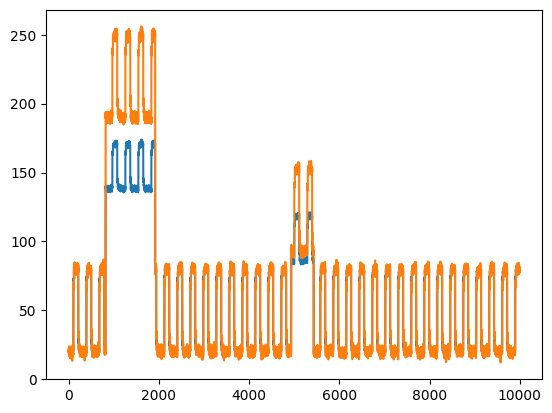

In [234]:
plt.plot(y_predict[ntime_out:test_size])
plt.plot(y_test[:test_size-ntime_out])

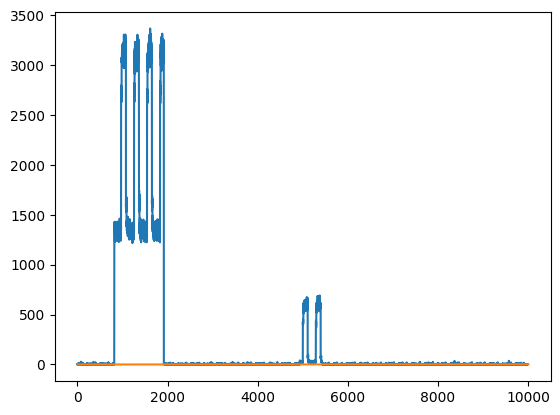

In [229]:
plt.plot(MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
#plt.plot(y_test[:test_size-ntime_out]-y_predict[ntime_out:test_size])
plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
#plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값

In [238]:
a=y_test[:test_size-ntime_out]
b=y_predict[ntime_out:test_size]
for i in range(2000):
    if(a[i]> 100):
        print("test",i)
    if(b[i]> 100):
        print("perdict",i)

test 818
perdict 818
test 819
perdict 819
test 820
perdict 820
test 821
perdict 821
test 822
perdict 822
test 823
perdict 823
test 824
perdict 824
test 825
perdict 825
test 826
perdict 826
test 827
perdict 827
test 828
perdict 828
test 829
perdict 829
test 830
perdict 830
test 831
perdict 831
test 832
perdict 832
test 833
perdict 833
test 834
perdict 834
test 835
perdict 835
test 836
perdict 836
test 837
perdict 837
test 838
perdict 838
test 839
perdict 839
test 840
perdict 840
test 841
perdict 841
test 842
perdict 842
test 843
perdict 843
test 844
perdict 844
test 845
perdict 845
test 846
perdict 846
test 847
perdict 847
test 848
perdict 848
test 849
perdict 849
test 850
perdict 850
test 851
perdict 851
test 852
perdict 852
test 853
perdict 853
test 854
perdict 854
test 855
perdict 855
test 856
perdict 856
test 857
perdict 857
test 858
perdict 858
test 859
perdict 859
test 860
perdict 860
test 861
perdict 861
test 862
perdict 862
test 863
perdict 863
test 864
perdict 864
test 865
perd

In [239]:
perdict_error =MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size])
perdict_error = perdict_error.reshape(len(perdict_error))
perdict_error.shape

(9994,)

In [240]:
real_error = np.array(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
real_error.shape

(9994,)

In [247]:
evaluation(perdict_error,real_error,5)

(0.7132279367620572,
 0.5248677248677248,
 0.4948453608247423,
 0.7878195278670206)